<a href="https://colab.research.google.com/github/silviasd2025-bit/dea_studies/blob/main/20250918_dea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import subprocess
subprocess.check_call(['pip', 'install', 'pulp'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

0

In [27]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [5]:
# The core DEA class, setting up and solving the linear programming
# problems using PuLP.

import pandas as pd
import pulp


class DEAProblem:

    """
    A container for the elements of a data envelopment analysis problem. Sets
    up the linear programmes and solves them with pulp.

    Requires:

        inputs: a pandas dataframe of the inputs to the DMUs
        outputs: a pandas dataframe of the outputs from the DMUs
        kind: 'VRS' or 'CRS'
        in_weights: the weight restriction to apply to all inputs to all DMUs
                    (default is [0, inf])
        out_weights: the weight restriction to apply to all outputs to all DMUs
                     (default is [0, inf)

    Weight restrictions must be specified as a list. To specify only one bound
    leave the other as None, eg. in_weights=[1, None].

    """

    def __init__(self, inputs, outputs, returns='CRS',
                 in_weights=[0, None], out_weights=[0, None]):
        """
        Set up the DMUs' problems, ready to solve.

        """
        self.inputs = _to_dataframe(inputs)
        self.outputs = _to_dataframe(outputs)
        self.returns = returns

        self.J, self.I = self.inputs.shape  # no of firms, inputs
        _, self.R = self.outputs.shape  # no of outputs
        self._i = range(self.I)  # inputs
        self._r = range(self.R)  # outputs
        self._j = range(self.J)  # DMUs

        self._in_weights = in_weights  # input weight restrictions
        self._out_weights = out_weights  # output weight restrictions

        # creates dictionary of pulp.LpProblem objects for the DMUs
        self.dmus = self._create_problems()

    def _create_problems(self):
        """
        Iterate over the inputs and create a dictionary of LP problems, one
        for each DMU.

        """

        dmu_dict = {}
        for j0 in self._j:
            dmu_dict[j0] = self._make_problem(j0)
        return dmu_dict

    def _make_problem(self, j0):
        """
        Create a pulp.LpProblem for a DMU.

        """

        # Set up pulp
        prob = pulp.LpProblem("".join(["DMU_", str(j0)]), pulp.LpMaximize)
        self.inputWeights = pulp.LpVariable.dicts("inputWeight", (self._j, self._i),
                                                  lowBound=self._in_weights[0], upBound=self._in_weights[1])
        self.outputWeights = pulp.LpVariable.dicts("outputWeight", (self._j, self._r),
                                                   lowBound=self._out_weights[0], upBound=self._out_weights[1])

        # Set returns to scale
        if self.returns == "CRS":
            w = 0
        elif self.returns == "VRS":
            w = pulp.LpVariable.dicts("w", (self._j, self._r))
        else:
            raise Exception(ValueError)

        # Set up objective function
        prob += pulp.LpAffineExpression(
            [(self.outputWeights[j0][r1], self.outputs.values[j0][r1]) for r1 in self._r]) - w

        # Set up constraints
        prob += pulp.LpAffineExpression([(self.inputWeights[j0][i1],
                                          self.inputs.values[j0][i1]) for i1 in self._i]) == 1, "Norm_constraint"
        for j1 in self._j:
            prob += self._dmu_constraint(j0, j1) - \
                w <= 0, "".join(["DMU_constraint_", str(j1)])
        return prob

    def _dmu_constraint(self, j0, j1):
        """
        Calculate and return the DMU constraint for a single DMU's LP problem.

        """

        eOut = pulp.LpAffineExpression(
            [(self.outputWeights[j0][r1], self.outputs.values[j1][r1]) for r1 in self._r])
        eIn = pulp.LpAffineExpression(
            [(self.inputWeights[j0][i1], self.inputs.values[j1][i1]) for i1 in self._i])
        return eOut - eIn

    def _solver(self):
        """
        Iterate over the dictionary of DMUs' problems, solve them, and collate
        the results into a pandas dataframe.

        """

        sol_status = {}
        sol_weights = {}
        sol_efficiency = {}

        for ind, problem in list(self.dmus.items()):
            problem.solve()
            sol_status[ind] = pulp.LpStatus[problem.status]
            sol_weights[ind] = {}
            for v in problem.variables():
                sol_weights[ind][v.name] = v.varValue
            sol_efficiency[ind] = pulp.value(problem.objective)
        return sol_status, sol_efficiency, sol_weights

    def _build_weight_results_dict(self, sol_weights):
        """
        Rename weights from input and output column names, then build a
        pandas dataframe of all weights.

        """
        import re
        tmp_dict = {}
        for dmu, d in list(sol_weights.items()):
            tmp_dict[dmu] = {}
            for key, _ in list(d.items()):
                m = re.search(r'[0-9]+$',key)
                i = int(m.group(0))
                if key.startswith("input"):
                    tmp_dict[dmu]["in_" + str(self.inputs.columns[i])] = d[key]
                if key.startswith("output"):
                    tmp_dict[dmu][
                        "out_" + str(self.outputs.columns[i])] = d[key]
        weight_results = pd.DataFrame.from_dict(tmp_dict).T

        return weight_results

    def solve(self, sol_type='technical'):
        """"
        Solve the problem and create attributes to hold the solutions.

        Takes:
            sol_type: 'technical'/'allocative'/'economic'
            dmus: tuple defining range of DMUs to solve for.

        """

        if sol_type == 'technical':
            sol_status, sol_efficiency, sol_weights = self._solver()
            weight_results = self._build_weight_results_dict(sol_weights)
            status_df = pd.Series(sol_status, name='Status')
            status_df.index = self.inputs.index
            efficiency_df = pd.Series(sol_efficiency, name='Efficiency')
            efficiency_df.index = self.inputs.index

            return DEAResults((('Status', status_df),
                               ('Efficiency', efficiency_df),
                               ('Weights', weight_results)))
        else:
            print("Solution type not yet implemented.")
            print("Solving for technical efficiency instead.")
            self.solve()


class DEAResults(dict):

    """
    A class to hold the results of a DEAProblem and provide methods for
    their examination. Essentially a dictionary of pandas Series with
    methods for conducting particular operations on DEA results.

    """

#    def __init__(self):
#        super(DEAResults, self).__init__()
#        pass

    def find_comparators(self, dmu):
        """
        Return the DMUs that form the frontier for the specified DMU.

        """
        pass

    def env_corr(self, env_vars, qq_plot=False):
        """
        Determine correlations with environmental/non-discretionary variables
        using a logit regression. Tobit will be implemented when available
        upstream in statsmodels.

        Takes:
            env_vars: A pandas dataframe of environmental variables

        Returns:
            corr_mod: the statsmodels' model instance containing the inputs
                      and results from the logit model.

        Note that there can be no spaces in the variables' names.
        """

        import matplotlib.pyplot as plt
        from statsmodels.regression.linear_model import OLS
        from statsmodels.graphics.gofplots import qqplot

        env_data = _to_dataframe(env_vars)
        corr_data = env_data.join(self['Efficiency'])
        corr_mod = OLS.from_formula(
            "Efficiency ~ " + " + ".join(env_vars.columns), corr_data)
        corr_res = corr_mod.fit()

        #plot qq of residuals
        if qq_plot:
            qqplot(corr_res.resid, line='s')
            plt.title('Distribution of residuals')

        print(corr_res.summary())

        return corr_res


def _to_dataframe(indata):
    """
    Indexers require input to be a dataframe but the user may pass a
    series. Check and cast series to dataframes.

    """

    if type(indata) == pd.core.frame.DataFrame:
        return indata
    elif type(indata) == pd.core.series.Series:
        return pd.DataFrame(indata, columns=['input_data'])
    else:
        raise TypeError(
            "Input data is not a valid pandas DataFrame or Series.")


In [22]:
import pandas as pd
from datetime import datetime
import os
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', 7)
file_path = "/content/drive/MyDrive/data/20250914_DEA_EnergySecurityPaper2.xls"
i_installed_capacity_per_capita = pd.read_excel(file_path,sheet_name='I1-Installed Capacity Capita')
i_energy_diversification        = pd.read_excel(file_path,sheet_name='I2-Energy diversification HHI')
i_energy_import                 = pd.read_excel(file_path,sheet_name='I3-Energy import')
i_perc_renewable                = pd.read_excel(file_path, sheet_name='I4-%Renewable')

o_mwh_capita                    = pd.read_excel(file_path, sheet_name='O1-MWh capita')
o_gdp_capita                    = pd.read_excel(file_path, sheet_name='O2-GDP_capita')
o_electrification               = pd.read_excel(file_path, sheet_name='O3-Electrification')
o_carbon_intensity              = pd.read_excel(file_path, sheet_name='O4-carbon intensity')

range_countries = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
#range_countries = [1,3,5,6,9,10,15,17,18,19]
countries = i_installed_capacity_per_capita['(Capacity kW/person)'][range_countries]
print (len(countries))
print (countries)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
20
0                                     Argentina
1                                     Australia
2                                        Brazil
3                                        Canada
4                                         China
5                                        France
6                                       Germany
7                                         India
8                                     Indonesia
9                                         Italy
10                                        Japan
11                                       Mexico
12                                       Russia
13                                 Saudi Arabia
14                                 South Africa
15                                  South Korea
16                                       Turkey
17                               United Kingdom
18  

In [7]:
dir2write = datetime.now().strftime("/content/drive/MyDrive/out/%Y%m%d%H%M%S")
os.mkdir(dir2write )

In [23]:
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    print(range_vals)
    if range_vals == 0:
        print ("ERROR range_vals=0")
    #range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

In [24]:
# DEA accepts : 'VRS' or 'CRS'
returns = 'CRS'


# Create results DataFrame
results = pd.DataFrame({
     'DMU': countries,
    })

print (results.DMU)
l_results = []

for year in range(2000, 2024):

  print("\n\n\n")
  print ("*********************************************")
  print ("******* Processing year %s" % year)
  print ("\n\n\n")

  i_installed_capacity_per_capita_year    = pd.Series(list(i_installed_capacity_per_capita[year][range_countries]) ,
                                                      index=list(countries))
  # Low Diversification index HHI shows a high diversified energy portfolio
  i_energy_diversification_year           = pd.Series(list(i_energy_diversification[year][range_countries]),
                                                      index=list(countries))
  # Energy export interesting for DEA
  i_energy_import_year                    = pd.Series(list(i_energy_import[year][range_countries]), index=list(countries))
  i_perc_renewable_year                   = pd.Series(list(i_perc_renewable[year][range_countries]), index=list(countries))

  o_mwh_capita_year              = pd.Series(list(o_mwh_capita[year][range_countries]), index = list(countries))
  o_gdp_capita_year              = pd.Series(list(o_gdp_capita[year][range_countries]), index = list(countries))
  o_electrification_year         = pd.Series(list(o_electrification[year][range_countries]), index = list(countries))
  # Interested in low carbon intensity
  o_carbon_intensity_year        = pd.Series(list(o_carbon_intensity[year][range_countries]), index = list(countries))


  i_installed_capacity_per_capita_year_norm = normalize_data(i_installed_capacity_per_capita_year)
  i_inv_energy_diversification_year_norm    = normalize_data(1.0/i_energy_diversification_year)
  i_energy_export_year_norm                 = normalize_data(-1 * i_energy_import_year)
  i_renewable_year_norm                     = normalize_data(i_perc_renewable_year)


  o_mwh_capita_year_norm                    = normalize_data(o_mwh_capita_year)
  o_gdp_capita_year_norm                    = normalize_data(o_gdp_capita_year)
  o_electrification_year_norm               = normalize_data(o_electrification_year)
  o_inv_carbon_intensity_year_norm          = normalize_data(1.0/o_carbon_intensity_year)

  inputs_dea = pd.DataFrame({#'Inverse Energy Diversification (norm)': i_inv_energy_diversification_year_norm,
                             'Energy Export (norm)': i_energy_export_year_norm,
                             'Renewable Energy (norm)': i_renewable_year_norm,
                             'Installed Capacity per Capita (norm)': i_installed_capacity_per_capita_year_norm,

                            })

  outputs_dea = pd.DataFrame({#'MWH per Capita (norm)': o_mwh_capita_year_norm,
                              'GDP per Capita (norm)':o_gdp_capita_year_norm,
                              #'Electrification': o_electrification_year,
                              'Inverse Carbon Intensity (norm)': o_inv_carbon_intensity_year_norm
                                  })

  print("------------\n\n)")
  print ("Inputs :")
  print("------------\n\n)")
  print (inputs_dea)

  print("------------\n\n)")
  print ("Outputs :")
  print("------------\n\n)")
  print (outputs_dea)

  prob = DEAProblem(inputs_dea, outputs_dea, returns=returns)
  myresults = prob.solve()

  print ('----------------\n\n\n')
  print ('*** Status ***')
  print ('----------------\n\n\n')
  print (myresults['Status'])

  print ('----------------\n\n\n')
  print ('*** Efficiency ***')
  print ('----------------\n\n\n')
  print (myresults['Efficiency'])
  l_results.append(myresults['Efficiency'])
  results[year] = myresults['Efficiency'].values

  print ('----------------\n\n\n')
  print ('----------------\n\n\n')
  print('*** Weights ***')
  print('----------------\n\n\n')

  print (type(myresults['Weights']))
  print (myresults['Weights'])


  print (results[year])
  with pd.ExcelWriter(os.path.join(dir2write,"dea_out_"+ str(year)  + '.xlsx')) as writer:
              inputs_dea.to_excel(writer, sheet_name='Inputs')
              outputs_dea.to_excel(writer, sheet_name='Outputs')
              myresults['Status'].to_excel(writer, sheet_name='Status')
              myresults['Efficiency'].to_excel(writer, sheet_name='Efficiency')
              myresults['Weights'].to_excel(writer, sheet_name='Weights')

  if  os.path.exists(os.path.join(dir2write, "dea_efficiency.xlsx")):
    with pd.ExcelWriter(os.path.join(dir2write, "dea_efficiency.xlsx"), mode='a', if_sheet_exists='replace') as writer2eff:
                     myresults['Efficiency'].to_excel(writer2eff, sheet_name=str(year))
  else:
    with pd.ExcelWriter(os.path.join(dir2write, "dea_efficiency.xlsx"), mode='w') as writer2eff:
                     myresults['Efficiency'].to_excel(writer2eff, sheet_name=str(year))

  if os.path.exists(os.path.join(dir2write, "dea_weights.xlsx")):
              with pd.ExcelWriter(os.path.join(dir2write, "dea_weights.xlsx"), mode='a', if_sheet_exists='replace') as writer2eff:
                     myresults['Weights'].to_excel(writer2eff, sheet_name=str(year))
  else:
              with pd.ExcelWriter(os.path.join(dir2write, "dea_weights.xlsx"), mode='w') as writer2eff:
                     myresults['Weights'].to_excel(writer2eff, sheet_name=str(year))

  if os.path.exists(os.path.join(dir2write, "dea_status.xlsx")):
              with pd.ExcelWriter(os.path.join(dir2write, "dea_status.xlsx"), mode='a', if_sheet_exists='replace') as writer2eff:
                     myresults['Status'].to_excel(writer2eff, sheet_name=str(year))
  else:
              with pd.ExcelWriter(os.path.join(dir2write, "dea_status.xlsx"), mode='w') as writer2eff:
                     myresults['Status'].to_excel(writer2eff, sheet_name=str(year))

Streaming output truncated to the last 5000 lines.
Brazil                                                  0.216434   
Canada                                                  0.895418   
China                                                   0.131221   
France                                                  0.837565   
Germany                                                 0.853327   
India                                                   0.100000   
Indonesia                                               0.114606   
Italy                                                   0.770852   
Japan                                                   0.733538   
Mexico                                                  0.266098   
Russia                                                  0.247267   
Saudi Arabia                                            0.420336   
South Africa                                            0.201527   
South Korea                                             0.520410 

In [25]:
results.head(20)


,DMU,2000,2001,...,2021,2022,2023
0,Argentina,0.626063,0.637320,...,0.441045,0.538091,0.517212
1,Australia,0.587247,0.549479,...,1.000000,1.000000,1.000000
2,Brazil,1.000000,1.000000,...,0.854849,1.000000,1.000000
3,Canada,0.375675,0.399332,...,0.544650,0.582074,0.551708
4,China,0.484017,0.510519,...,0.347486,0.343060,0.311039
5,France,1.000000,1.000000,...,1.000000,1.000000,1.000000
6,Germany,0.816201,0.883107,...,0.947334,0.994674,1.000000
7,India,0.613856,0.647700,...,0.545340,0.570348,0.585150
8,Indonesia,0.674617,0.708945,...,0.791002,0.844163,0.854046
9,Italy,0.750645,0.847408,...,0.991546,1.000000,1.000000


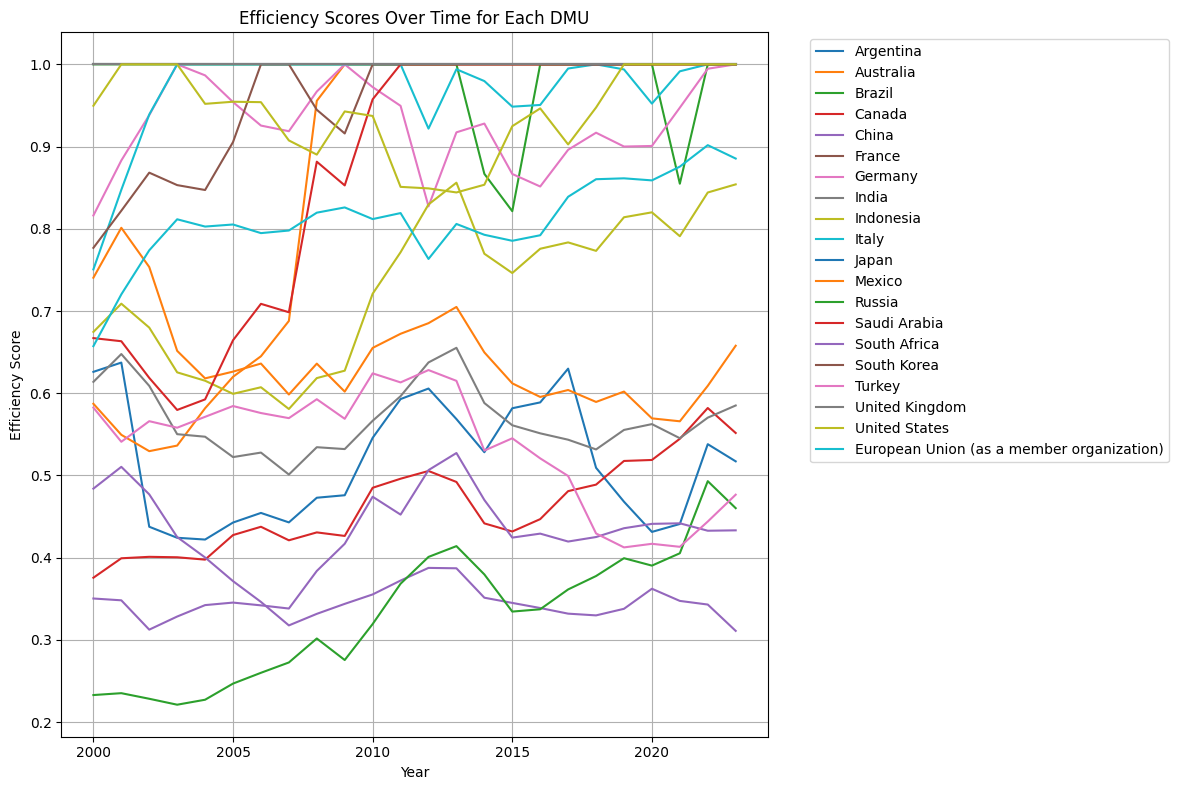

In [28]:
plt.figure(figsize=(12, 8))
for index, row in results.iterrows():
    dmu = row['DMU']
    efficiencies = row[results.columns[1:]].values  # Exclude 'DMU' column
    years = results.columns[1:]  # Exclude 'DMU' column
    #print(years)
    #print (efficiencies)
    plt.plot(years, efficiencies, label=dmu)

plt.xlabel('Year')
plt.ylabel('Efficiency Score')
plt.title('Efficiency Scores Over Time for Each DMU')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

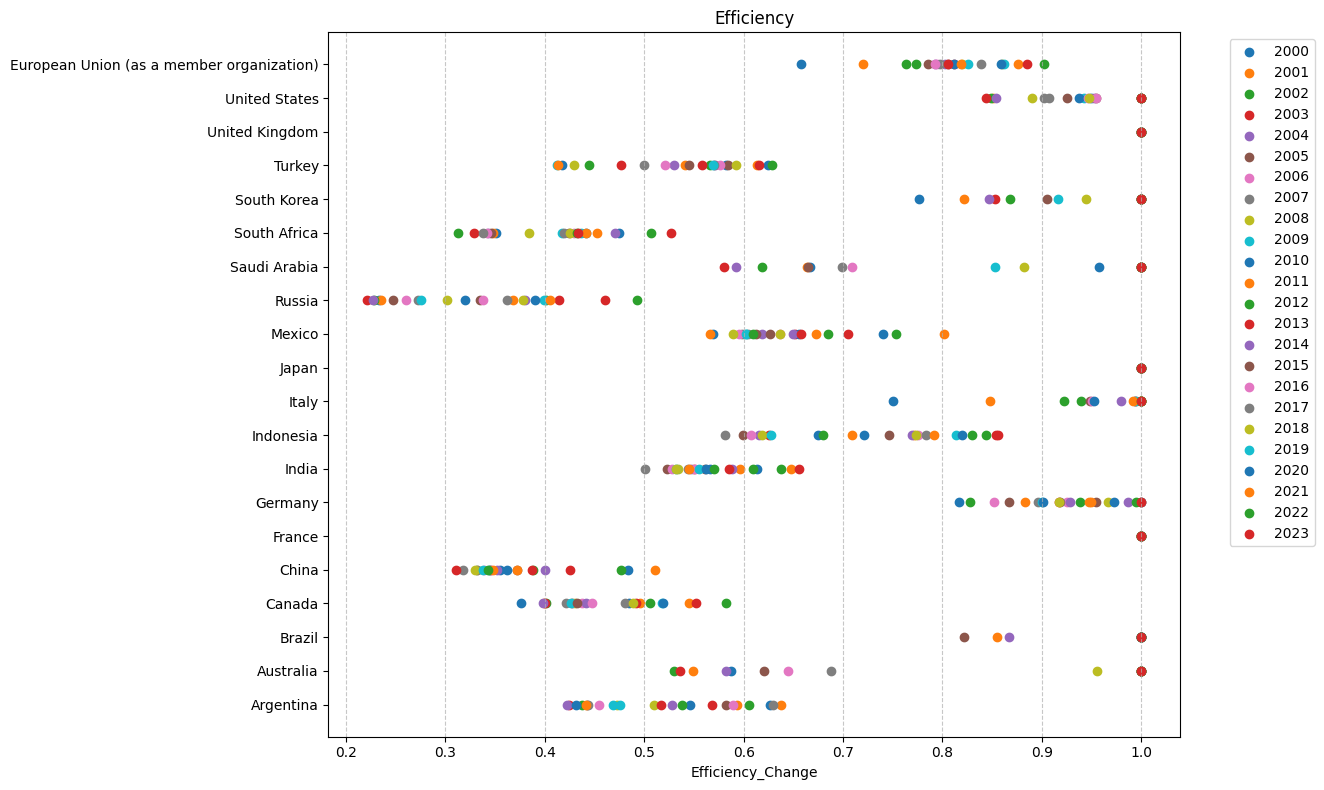

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

for year in range(2000,2024):
  # Create the figure and ax  is


  # Plot the mean EC points

  #print (results[year])
  #print(range(len(results)))

  ax.scatter(results[year], range(len(results)), label=str(year))

  # Plot the confidence intervals
  #for idx, row in df4.iterrows():
  #    ax.hlines(y=df4.index.get_loc(idx),
  #              xmin=row['Eff_CI_Lower'],
  #              xmax=row['Eff_CI_Upper'],
  #              color='blue',
  #              alpha=0.3)

  # Customize the plot
ax.set_yticks(range(len(results)))
ax.set_yticklabels(results['DMU'])
ax.set_xlabel('Efficiency_Change')
ax.set_title('Efficiency')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()